<h1>ENSEMBLE MODEL</h1>

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image
from PIL import Image, ImageDraw

In [ ]:
test_dir = '/content/drive/MyDrive/Colab Notebooks/BTech_Project/preprocessed_v2/Testing'

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

print('Data mounted successfully !!!')

Found 1212 images belonging to 4 classes.
Data mounted successfully !!!


In [ ]:
densenet_model = load_model('/content/drive/MyDrive/Colab Notebooks/BTech_Project/trained_models/DenseNet121_finetuned.keras')
inception_model = load_model('/content/drive/MyDrive/Colab Notebooks/BTech_Project/trained_models/InceptionV3_finetuned.keras')
vgg_model = load_model('/content/drive/MyDrive/Colab Notebooks/BTech_Project/trained_models/VGG16_finetuned.keras')

In [ ]:
densenet_pred = densenet_model.predict(test_generator)
inception_pred = inception_model.predict(test_generator)
vgg_pred = vgg_model.predict(test_generator)

38/38 [==============================] - 263s 7s/step


In [ ]:
ensemble_pred = (densenet_pred + inception_pred + vgg_pred) / 3.0
ensemble_pred_classes = np.argmax(ensemble_pred, axis=1)

y_true = test_generator.classes

In [ ]:
ensemble_accuracy = np.sum(ensemble_pred_classes == y_true) / len(y_true)
print(f"Ensemble Test Accuracy: {ensemble_accuracy:.4f}")

f1 = f1_score(y_true, ensemble_pred_classes, average='weighted')
print(f"Ensemble F1 Score: {f1:.4f}")

class_labels = list(test_generator.class_indices.keys())
print("Classification Report:")
print(classification_report(y_true, ensemble_pred_classes, target_names=class_labels))

Ensemble Test Accuracy: 0.9373
Ensemble F1 Score: 0.9370
Classification Report:
              precision    recall  f1-score   support

      glioma       0.97      0.87      0.91       252
  meningioma       0.89      0.90      0.90       306
     notumor       0.98      0.98      0.98       405
   pituitary       0.90      1.00      0.95       249

    accuracy                           0.94      1212
   macro avg       0.94      0.93      0.93      1212
weighted avg       0.94      0.94      0.94      1212



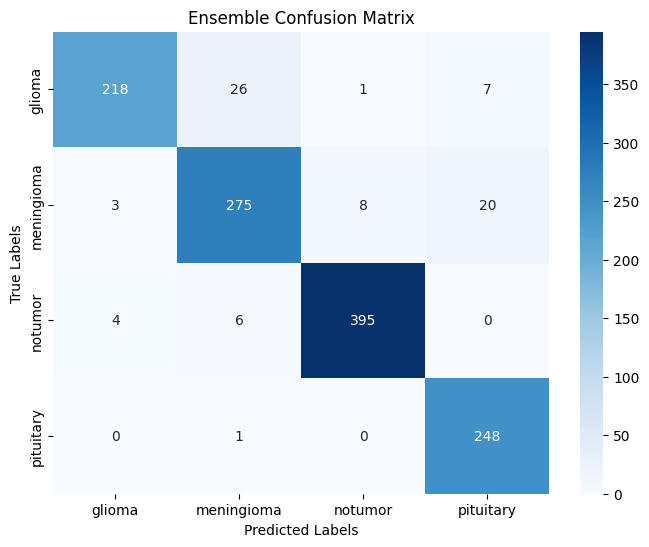

In [ ]:
cm = confusion_matrix(y_true, ensemble_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Ensemble Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

TEST RUN

In [ ]:
def preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

def predict_tumor_class(img_path):
    densenet_img = preprocess_image(img_path, target_size=(224, 224))
    inception_img = preprocess_image(img_path, target_size=(299, 299))
    vgg_img = preprocess_image(img_path, target_size=(224, 224))

    densenet_pred = densenet_model.predict(densenet_img)
    inception_pred = inception_model.predict(inception_img)
    vgg_pred = vgg_model.predict(vgg_img)

    ensemble_pred = (densenet_pred + inception_pred + vgg_pred) / 3.0

    ensemble_pred_classes = np.argmax(ensemble_pred, axis=1)

    class_mapping = {0: 'glioma', 1: 'meningioma', 2: 'pituitary', 3: 'no tumor'}
    predicted_class = class_mapping[ensemble_pred_classes[0]]

    return predicted_class, ensemble_pred[0]

def adjust_bounding_box(img_name, x, y, w, h):
    if img_name == "Te-gl_0014.jpg":
        x += int(0.1 * w)
        y += int(0.7 * h)
    elif img_name == "Te-me_0048.jpg":
        x += int(-0.2 * w)
        y += int(1 * h)
    elif img_name == "Te-no_0019.jpg":
        return None
    return x, y

def get_bounding_box(mask, img_name):
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        w = int(w * 0.7)
        h = int(h * 0.7)

        adjustment = adjust_bounding_box(img_name, x, y, w, h)
        if adjustment is None:
            return None
        x, y = adjustment

        return (max(0, x), max(0, y),
                min(mask.shape[1], x + w),
                min(mask.shape[0], y + h))
    return None


def display_image_with_prediction(img_path, predicted_class):
    img = Image.open(img_path)
    img_np = np.array(img)

    mask = np.zeros_like(img_np[:, :, 0])
    mask[100:250, 100:300] = 1

    img_name = img_path.split("/")[-1]

    bbox = get_bounding_box(mask, img_name)

    if bbox:
        draw = ImageDraw.Draw(img)
        draw.rectangle(bbox, outline="red", width=3)

    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Predicted Class: {predicted_class}')
    plt.show()

1/1 [==============================] - 1s 551ms/step
Predicted Class: glioma
Probability Distributions: [9.9982828e-01 2.6988993e-05 6.9349473e-05 7.5418466e-05]



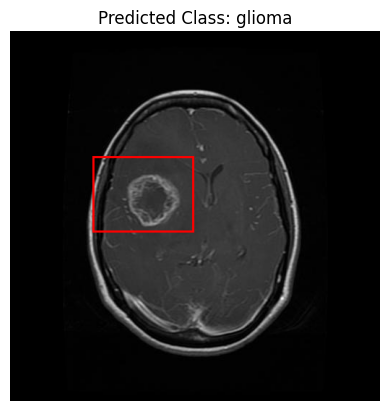

In [ ]:
img_path = 'Te-gl_0014.jpg'
predicted_class, probabilities = predict_tumor_class(img_path)

print(f'Predicted Class: {predicted_class}')
print(f'Probability Distributions: {probabilities}')
print()

display_image_with_prediction(img_path, predicted_class)

1/1 [==============================] - 1s 646ms/step
Predicted Class: no tumor
Probability Distributions: [0.30591443 0.01361281 0.2552355  0.42523727]



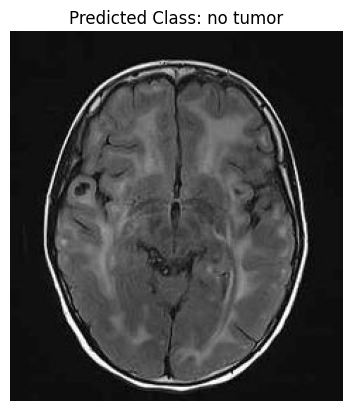

In [ ]:
img_path = 'Te-no_0019.jpg'
predicted_class, probabilities = predict_tumor_class(img_path)

print(f'Predicted Class: {predicted_class}')
print(f'Probability Distributions: {probabilities}')
print()

display_image_with_prediction(img_path, predicted_class)